In [2]:
#!pip install --upgrade hyperspectral_gta_data

In [3]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# set the directory where data will be downloaded and accessed
# (This directory will be saved in a config file and used each time you use hyperspectral_gta_data, 
# so you don't need to run the 'set_data_dir' function every time you use hyperspectral_gta_data.)
hsi_data.set_data_dir('C:/spectral_data')

## In this notebook, we will introduce target detection.

With target detection, we have two data sets:
1. **A hyperspectral image.**
2. **Target spectra.**

The target spectra are usually collected from known materials that we want to find in the iamge.

The data preparation includes:
1. **Load Data:** Load the image and spectral library.
2. **Check Data Scale:** Check that the iamge and library have the same scale. Ideally, they are both on a 0-1 scale for reflectance units, but:
    i. Sometimes data are stored in 16-bit integer data type to save memory and resources.  In that case, they are often on a 0-1000 scale.
    ii. Often, the values for spectral data are too large or small due to (1) changes in sunlight and shadow, (2) problems in atmospherice correction, converting from radiance to reflectance, or (3) calibration of sensors.
3. **Check Wavelengths:** Check that the image and spectra have wavelengths in the same units (both nanometers or both micrometers) and have the same values.  If the units are different, we simply multiply or divide by 1000 as needed.  If the wavelength values are different, we have to resample the data. Almost always, this means resampling the library to the wavelengths of the image, because the library usually has higher spectral resolution (more bands with more tightly-spaced wavelengths).
4. **Quality Check:** Do a quality check on the data and spectra.  If the light source for either is the sun, then there will be bands where the atmosphere (mostly water vapor) absorbs most of the light.  These need to be removed from the data, and then the resampling is needed as in Step 3.

After these are completed, we will be ready for target deteciton.

# 1. Download the data

In [4]:
# Here are the datasets available through the hyperspectral_gta_data package
hsi_data.available_datasets()

Available Images:
   WashingtonDC
   MicroscenePolymers
   Detection_Imagery_Cooke_City_RIT
   VegBaccharisUPWINS
   PaintDetectionUPWINS
   indian_pines
   pavia_centre
   pavia_university
Available Spectral Libraries:
   GHISACONUS_2008_001_speclib
   Microscene_Polymers_Library
   UPWINS_4_16_2024
   Detection_Library_Cooke_City_RIT


## Download the hyperspectral image

In this case, we will be using a hyperspectral image from the RIT test over Cooke City, Montana. (https://dirsapps.cis.rit.edu/blindtest/)

In [5]:
# Download and use the Cooke Cite image:
hsi_data.download('Detection_Imagery_Cooke_City_RIT')
fname = hsi_data.get_fname('Detection_Imagery_Cooke_City_RIT')

Available Files:
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\blind_test_refl
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\blind_test_refl.hdr
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\blind_test_refl.img
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\IGARSS_2008_Snyder.pdf
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\self_test_refl
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\self_test_refl.hdr
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\self_test_refl.img
C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT\self_test_refl_gt.txt
Primary Image Filename:
C:/spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT/self_test_refl


In [11]:
# load the Cooke City hyperspectral iamge
fname = 'C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT/self_test_refl'
fname_hdr = 'C:\spectral_data\spectral_images\Detection_Imagery_Cooke_City_RIT/self_test_refl.hdr'

# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
wl_im = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
imArr = im.Arr
print(f'Shape of ImArr = {imArr.shape}')
imList = np.reshape(imArr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of imList = {imList.shape}')

Shape of ImArr = (280, 800, 126)
Shape of imList = (224000, 126)


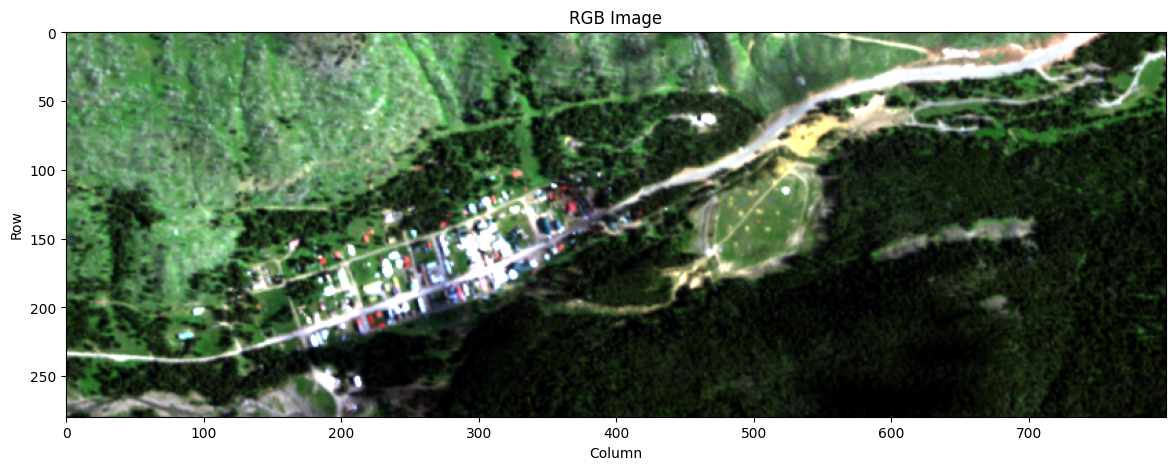

In [7]:
# display the image
sm2.display_RGB(imArr, wl, rotate=False)
plt.title('RGB Image');

In [8]:
# explore the image in our hyperspectral image viewer
from hsiViewer import hsi_viewer as hv
hv.viewer(im)

# Download the Spectral Library fopr Target Detection

In [9]:
# To download and use the Cooke City spectral library image:
hsi_data.download('Detection_Library_Cooke_City_RIT')
fname = hsi_data.get_fname('Detection_Library_Cooke_City_RIT')

Available Files:
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Cooke_City_Targets
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Cooke_City_Targets.hdr
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Photos\F1.jpg
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Photos\F2.jpg
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Photos\F3.jpg
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Photos\F4.jpg
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Photos\F5.jpg
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Photos\F6.jpg
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Photos\F7.jpg
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Photos\V1.jpg
C:\spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT\Photos\V2.jpg
C:\spectral_data\spectral_libraries\Detection_Library_Co

In [12]:
fname = 'C:/spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT/Cooke_City_Targets'
fname_hdr = 'C:/spectral_data\spectral_libraries\Detection_Library_Cooke_City_RIT/Cooke_City_Targets.hdr'

# Open the image and read into an array
lib = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
names = lib.names
spectra = lib.spectra
wl_lib = np.asarray(lib.bands.centers)

In [ ]:
resampler = spectral.BandResampler(wl_lib, wl_im)

spectra_resampled = resampler(lib.spectra.T).T

spectra_resampled.shape

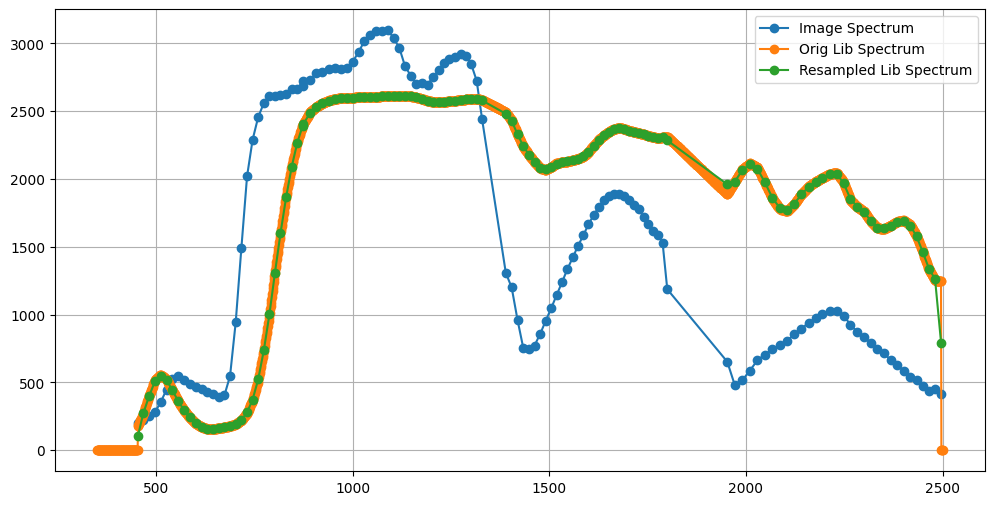

In [36]:
plt.figure(figsize=(12,6))
plt.plot(wl_im, imArr[100,100,:].flatten(), marker='o', label='Image Spectrum')
plt.plot(wl_lib, spectra[5,:].flatten(), marker='o', label='Orig Lib Spectrum')
plt.plot(wl_im, spectra_resampled[5,:].flatten(), marker='o', label='Resampled Lib Spectrum')
plt.grid()
plt.legend()

In [23]:
spectra_resampled.shape

(126, 18)

# check that the library spectra and image spectra are on the same scale.

# Matched Filter Target Detection

In [9]:
C = np.cov(imList.T) 
m = np.mean(imList, axis=0)

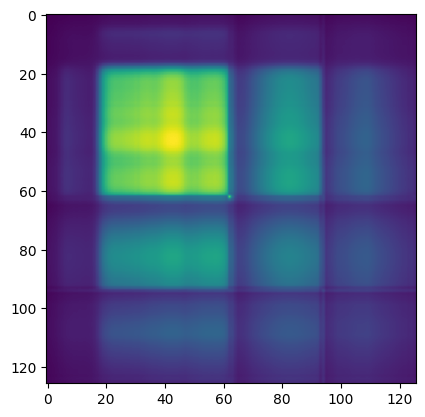

In [ ]:
plt.imshow(C);

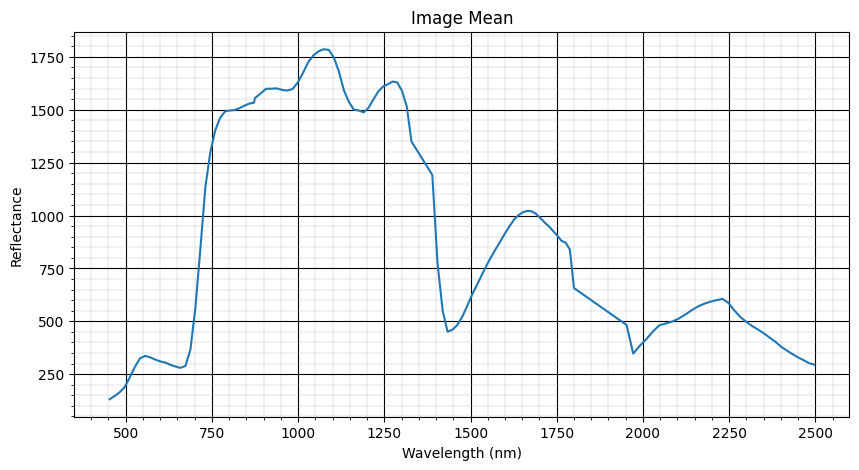

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(wl, m)
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title('Image Mean')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance');

## Whiten the Image

In [ ]:
# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)
ImListDemean = imList - m
WimList = np.matmul(W.T, ImListDemean.T).T

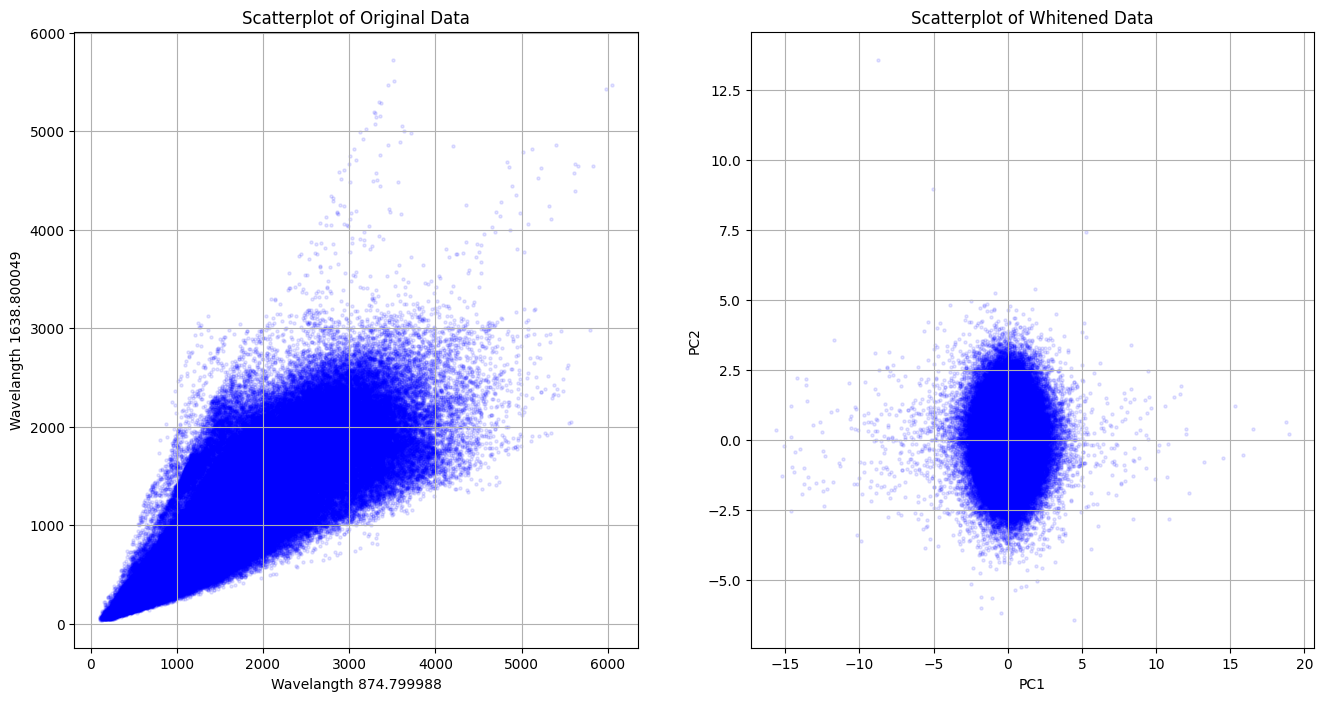

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)  
plt.title('Scatterplot of Original Data')
plt.scatter(imList[:,30],imList[:,80], s=5, c='b', alpha=0.1)
plt.xlabel(f'Wavelangth {wl[30]}')
plt.ylabel(f'Wavelangth {wl[80]}')
plt.grid(True)

plt.subplot(1, 2, 2)  
plt.title('Scatterplot of Whitened Data')
plt.scatter(WimList[:,30],WimList[:,80], s=5, c='b', alpha=0.1)
plt.xlabel(f'PC1')
plt.ylabel(f'PC2');
plt.grid(True)

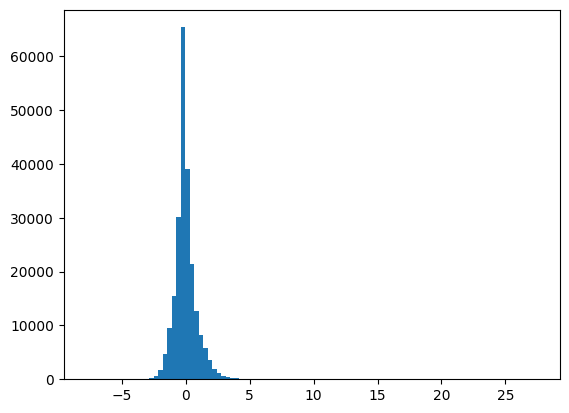

In [ ]:
plt.hist(WimList[:,3].flatten(), bins=100);

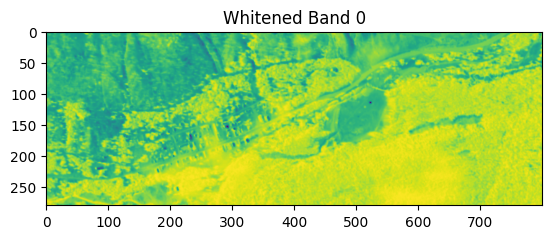

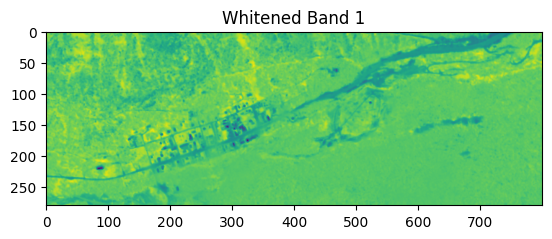

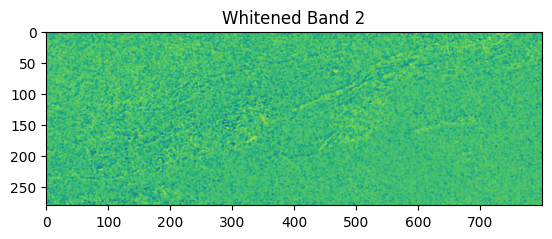

In [ ]:
for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(WimList[:,i], (im.nrows,im.ncols)))
    plt.title(f'Whitened Band {i}')

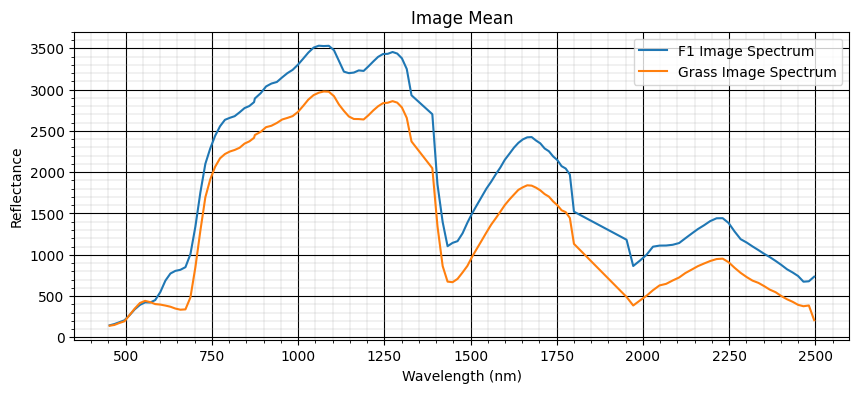

In [ ]:
F1_idx = [137,503]
imSpec_F1 = imArr[F1_idx[0], F1_idx[1], :].flatten()
Grass_idx = [139,507]
imSpec_Gr = imArr[Grass_idx[0], Grass_idx[1], :].flatten()

plt.figure(figsize=(10,4))
plt.plot(wl, imSpec_F1, label='F1 Image Spectrum')
plt.plot(wl, imSpec_Gr, label='Grass Image Spectrum')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title('Image Mean')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend();



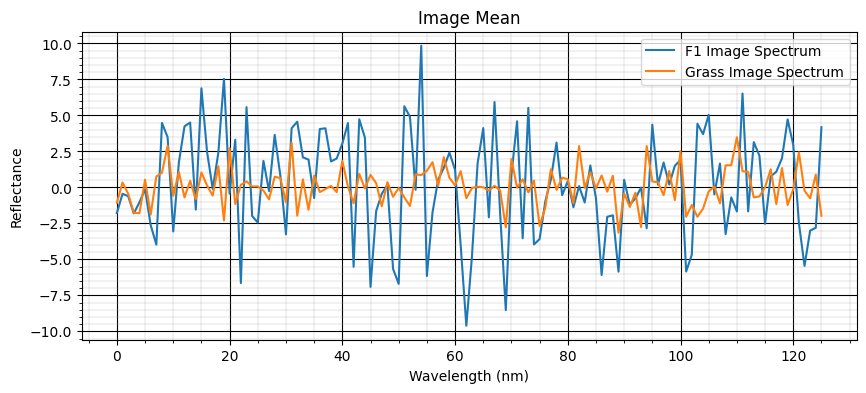

In [ ]:
WimArr = np.reshape(WimList, (im.nrows,im.ncols,im.nbands))
F1_idx = [137,503]
WimSpec_F1 = WimArr[F1_idx[0], F1_idx[1], :].flatten()
Grass_idx = [139,507]
WimSpec_Gr = WimArr[Grass_idx[0], Grass_idx[1], :].flatten()


plt.figure(figsize=(10,4))
plt.plot(WimSpec_F1, label='F1 Image Spectrum')
plt.plot(WimSpec_Gr, label='Grass Image Spectrum')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title('Image Mean')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend();

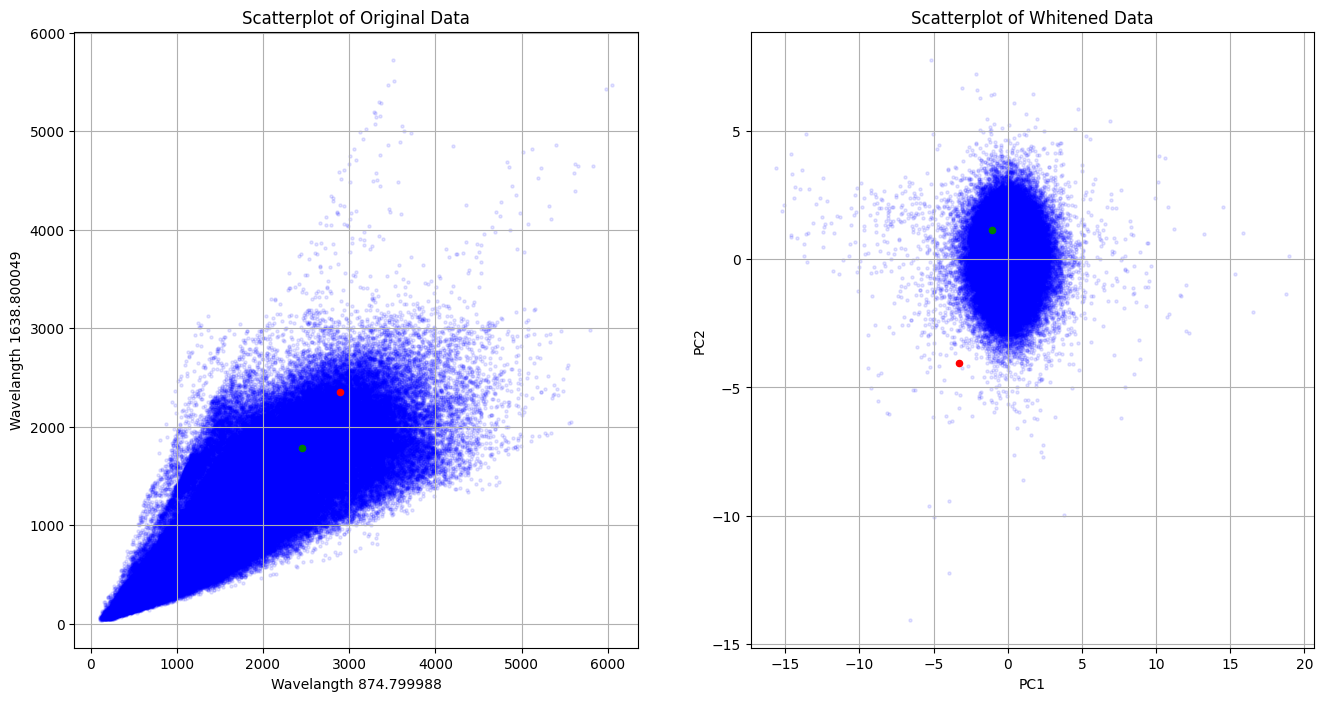

In [ ]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)  Book_Modules/M6 Anomaly Detection.ipynb
plt.title('Scatterplot of Original Data')
plt.scatter(imList[:,30],imList[:,80], s=5, c='b', alpha=0.1)
plt.scatter(imSpec_Gr[30], imSpec_Gr[80], c='g', s=20)
plt.scatter(imSpec_F1[30], imSpec_F1[80], c='r', s=20)
plt.xlabel(f'Wavelangth {wl[30]}')
plt.ylabel(f'Wavelangth {wl[80]}')
plt.grid(True)

PC1 = 30
PC2 = 61
plt.subplot(1, 2, 2)  
plt.title('Scatterplot of Whitened Data')
plt.scatter(WimList[:,PC1],WimList[:,PC2], s=5, c='b', alpha=0.1)
plt.scatter(WimSpec_Gr[PC1], WimSpec_Gr[PC2], c='g', s=20)
plt.scatter(WimSpec_F1[PC1], WimSpec_F1[PC2], c='r', s=20)
plt.xlabel(f'PC1')
plt.ylabel(f'PC2');
plt.grid(True)

## Compute the RX Anomaly Detection Algorithm

In [ ]:
RX_list = np.sum(WimList**2, axis=1)
RX = np.reshape(RX_list, (im.nrows,im.ncols))

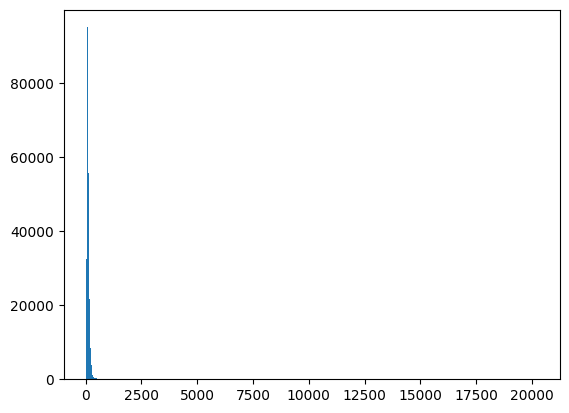

In [ ]:
plt.hist(RX_list, bins=500);

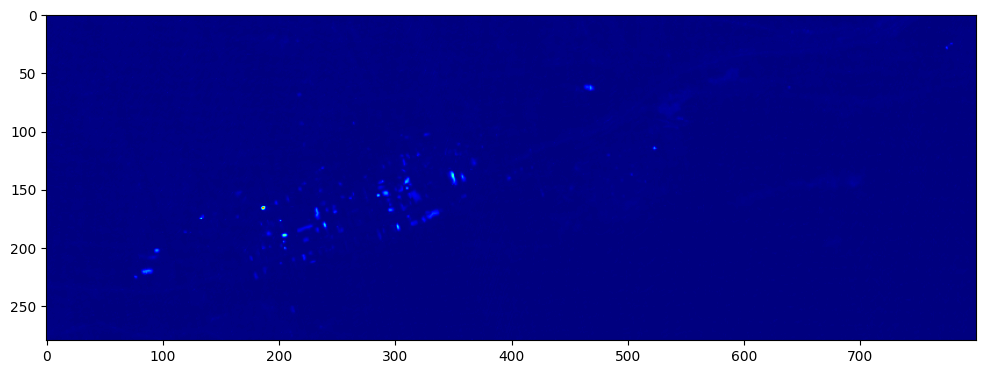

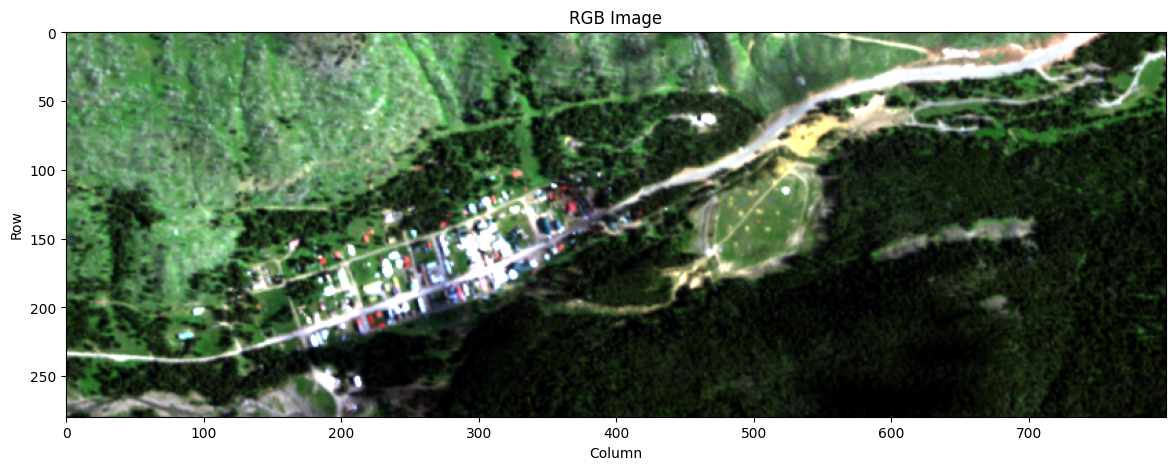

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(RX, cmap='jet')
sm2.display_RGB(imArr, wl, rotate=False)
plt.title('RGB Image');

In [ ]:
import hsi_viewer as hv
hv.viewer()